# Imports

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carregar dados

In [0]:
#Carrega o DataFrame
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/BeerrecipeData.csv',encoding='latin-1')

In [0]:
#Amostra das primeiras Linhas
df.head(2)

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0


# Tratamentos

## Trabalhando com valores faltantes

In [0]:
#Ver quais tem dados faltantes
df.isnull().sum()

BeerID               0
Name                 1
URL                  0
Style              596
StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity       2990
Efficiency           0
MashThickness    29864
SugarScale           0
BrewMethod           0
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
UserId           50490
dtype: int64

In [0]:
#df.City.mode() =ordem de valores que aparece mais vezes


## Remover Colunas Desnecessárias

In [0]:
df.drop(columns=['UserId','StyleID','URL','BeerID','PrimingAmount','PrimingMethod','PitchRate','PrimaryTemp','MashThickness','SugarScale','Name'],inplace=True,errors='ignore')
#Visto que duas colunas tem alta correlação, entao pode remover
#df['OG'].corr(df['BoilGravity'])
df.drop(columns=['BoilGravity','BoilSize'],inplace=True,errors='ignore')

## Transformando tipos de dados

In [0]:
#Transformar dados categoricos para seu tipo e tipo de numericos para formatos mais simples

df['Style'] = df['Style'].astype('category')
df['BrewMethod'] = df['BrewMethod'].astype('category')
df['Size(L)'] = df['Size(L)'].astype('float32')
df['OG'] = df['OG'].astype('float32')
df['FG'] = df['FG'].astype('float32')
df['ABV'] = df['ABV'].astype('float32')
df['IBU'] = df['IBU'].astype('float32')
df['BoilTime'] = df['BoilTime'].astype('int32')
df['Efficiency'] = df['Efficiency'].astype('float32')
#df['Date'] = pd.to_datetime(df.Date)

#Remover duplicadios
df.drop_duplicates(inplace=True)
#Remover nulos (pra esse caso de dataset)
df.dropna(inplace=True)

# Estatisticas
Mostra dados sobre o DataSet Carregado

## Report Completo

In [0]:
#Report completo com Profiling
pandas_profiling.ProfileReport(df)

Number of variables,11
Number of observations,73004
Total Missing (%),0.0%
Total size in memory,3.3 MiB
Average record size in memory,47.1 B
Numeric,8
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,1


## Outras Estatisticas

In [0]:
#Informação do DataSet
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73004 entries, 0 to 73860
Data columns (total 10 columns):
Style         73004 non-null category
Size(L)       73004 non-null float32
OG            73004 non-null float32
FG            73004 non-null float32
ABV           73004 non-null float32
IBU           73004 non-null float32
Color         73004 non-null float64
BoilTime      73004 non-null int32
Efficiency    73004 non-null float32
BrewMethod    73004 non-null category
dtypes: category(2), float32(6), float64(1), int32(1)
memory usage: 3.3 MB


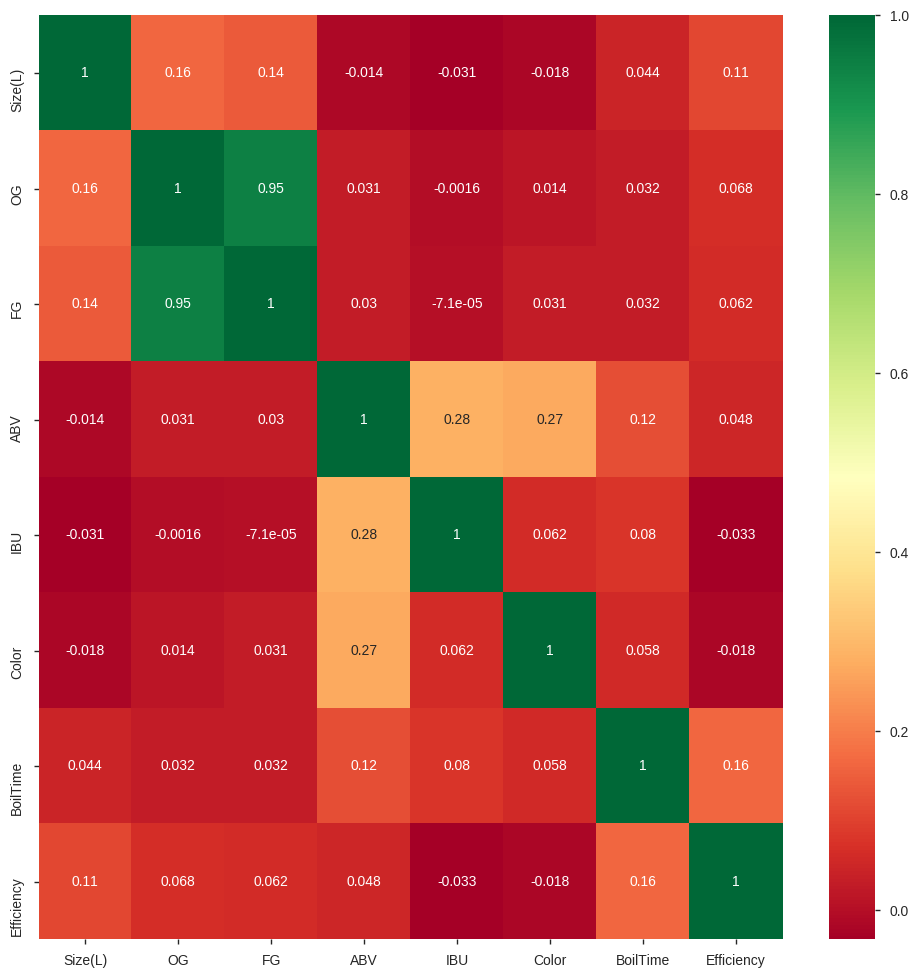

In [0]:
#Grafico de matriz de correlação
import seaborn as sns
#Heatmap
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12,12))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn",)

In [0]:
#Agrupamento por linha de produtos
#df.groupby(['Style','IBU']).agg({'ABV':np.size,'FG':np.mean})

# Pré Processamento de dados e Preparo do Modelo

In [0]:
#pegar os estilos que mais tem para não ficar com estilos de poucos dados no modelo
df = df[df.Style.isin( df.groupby('Style').size().nlargest(10).keys())]

## Separando Features e Targets
Separa os dados que serão analisados para treino, do nosso alvo

In [0]:
#Obter os valores de colunas e valores
X = df[df.Style.notnull()].iloc[:,2:] # Pèga todas as linhas, da coluna 2 em diante
y = df[df.Style.notnull()].iloc[:,0]
print(np.shape(X))
print(np.shape(y))

(33191, 8)
(33191,)


## Transformando Categoricos em Dummies
Transforma Categoricos em dados binários para que o modelo matematico funcione

In [0]:
dummies = pd.get_dummies(X.select_dtypes('category'),drop_first=True)
X_dummed = X.drop(columns=X.select_dtypes('category').columns)
X_dummed[dummies.columns] = dummies
X = X_dummed

In [0]:
X.head()

,OG,FG,ABV,IBU,Color,BoilTime,Efficiency,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
2,1.063,1.018,5.91,59.250000,8.98,60,70.0,0,0,1
3,1.061,1.017,5.80,54.480000,8.50,60,70.0,0,0,0
5,1.055,1.013,5.58,40.119999,8.00,70,79.0,0,0,0
6,1.072,1.018,7.09,268.709991,6.33,90,75.0,0,0,0
9,1.080,1.017,8.22,93.019997,8.29,60,70.0,0,0,0


## Escalando valores numericos
Normaliza e reduz a escala de valores númericos para melhor treino do modelo

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_toScale = X.iloc[:,0:10]
X[X_toScale.columns] =  sc.fit_transform(X_toScale)
#X= sc.fit_transform(X)

In [0]:
X.head()

,OG,FG,ABV,IBU,Color,BoilTime,Efficiency,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
2,-0.149398,-0.129315,-0.090387,0.132042,-0.156557,-0.300688,0.279615,-0.442995,-0.22103,2.669659
3,-0.150382,-0.132042,-0.167461,0.025407,-0.211434,-0.300688,0.279615,-0.442995,-0.22103,-0.374580
5,-0.153333,-0.142950,-0.321610,-0.295617,-0.268597,0.528234,0.915763,-0.442995,-0.22103,-0.374580
6,-0.144971,-0.129315,0.736408,4.814610,-0.459521,2.186080,0.633031,-0.442995,-0.22103,-0.374580
9,-0.141036,-0.132042,1.528170,0.886985,-0.235442,-0.300688,0.279615,-0.442995,-0.22103,-0.374580


## Separando treino e teste
Separa amostras do modelo para treinar, e outra para validar o acerto

In [0]:
#Separa amostras de treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#Outro metodo de fazer o split
#from sklearn.model_selection import ShuffleSplit

In [0]:
#X_train[X_train.columns] = X_train[X_train.columns].astype('float32')
X_train.dtypes

OG                         float64
FG                         float64
ABV                        float64
IBU                        float64
Color                      float64
BoilTime                   float64
Efficiency                 float64
BrewMethod_BIAB            float64
BrewMethod_Partial Mash    float64
BrewMethod_extract         float64
dtype: object

# Feature Selection
Verificando quais Features são as melhores para o modelo

<BarContainer object of 10 artists>

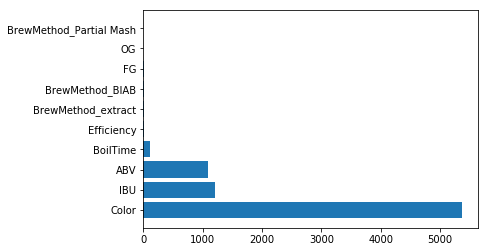

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


bestfeatures = SelectKBest( k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score') #print 10 best features


plt.barh(width=featureScores.nlargest(10,'Score').Score,y=featureScores.nlargest(10,'Score').Specs)

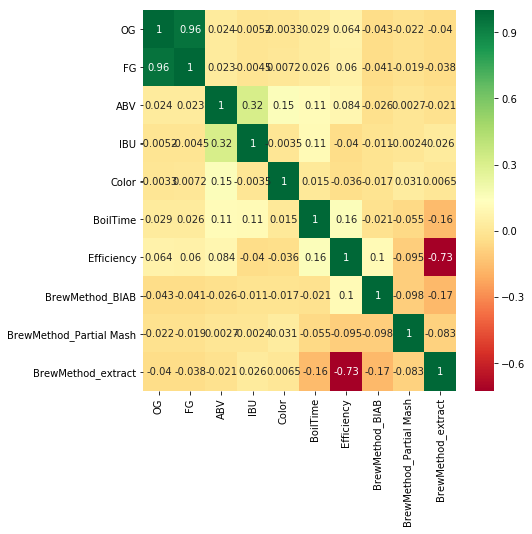

In [0]:
import seaborn as sns
#Heatmap
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(7,7))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [0]:
#Selecionando as melhores Features
X_train = X_train[['IBU','ABV','Color','BoilTime']]
X_test = X_test[['IBU','ABV','Color','BoilTime']]

# Classificação

In [0]:
#Funcoes de estatisticas
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Algoritimos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Exemplo de um classificador

In [0]:
#Exemplo de um unico classificador
LR = LogisticRegression()
LR.fit(X_train,y_train)
#pred = DC.predict(X_test)
#DC.score(X_test,y_test)

#from sklearn.model_selection import cross_val_score
#cross_val = cross_val_score(DC, X_test, y_test, cv=4,)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
LR.score(X_test,y_test)

0.4725234996384671

## Rodar multiplos algoritimos e escolher o melhor

In [0]:
#Vamos carregar varios algoritimos de classificação de uma vez e ver qual se sai melhor
#Coloca todos os algoritimos em uma lista
models = []
models.append(('LR', LogisticRegression(solver='lbfgs',multi_class='auto')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='scale')))

#Variaveis para verificar o melhor
scoring = 'accuracy'
results = []
names = []
seed = 7

#Roda cada um dos algoritimos e printa o score
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.527136 (0.009968)
LDA: 0.512513 (0.009545)
KNN: 0.566745 (0.009793)
CART: 0.495480 (0.010302)
NB: 0.454104 (0.013524)
SVM: 0.590728 (0.009737)


## GridSearch para encontrar melhores  hiperparametros

In [0]:
from sklearn.model_selection import GridSearchCV

model = SVC()
#Coloca varios tipos do parametro C da regressao logistica, para ver qual tem melhor resultado
GS = GridSearchCV(model, param_grid={'C':[0.001,0.01,0.1,1.0],'gamma':['auto','scale']},
scoring='accuracy', cv=4)

#Treinar e predizer o modelo
GS = GS.fit(X_train, y_train)
pred = GS.predict(X_test)

In [0]:
print(f'score:{GS.score(X_test,y_test)}')
print(GS.best_params_)
accuracy = accuracy_score(y_test, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

score:0.6196673897324656
{'C': 1.0, 'gamma': 'scale'}
Accuracy: 61.97%


##Treino com XBoost

In [0]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.89%


##Treino com Rede Neural

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import to_categorical

# para redes neurais
from sklearn.preprocessing import LabelEncoder
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
encoded_y_binary = to_categorical(encoded_y)

#Separa amostras de treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y_binary, test_size = 0.25, random_state = 0)


input_dim = len(X.columns) 

#Inicializar a ANN
classifier = Sequential()
#Add a input layer e a primeira hidden layer
classifier.add(Dense(output_dim = 10, kernel_initializer='uniform', activation='relu', input_dim = input_dim)) #  11 = independent vars
#Add a segunda hidden layer
classifier.add(Dense(output_dim = 20, kernel_initializer='uniform', activation='relu')) 
#Add a segunda hidden layer
classifier.add(Dense(output_dim = 15, kernel_initializer='uniform', activation='relu')) 
#Add a output layer
classifier.add(Dense(output_dim = np.shape(y_train)[1], init='uniform', activation='sigmoid')) 
#Compilar a ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# Fit o modelo
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)


Using TensorFlow backend.
W0728 02:55:20.633897 139816106710912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", input_dim=10, units=10)`
W0728 02:55:20.691335 139816106710912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 02:55:20.699119 139816106710912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launc

Epoch 1/100
24893/24893 [==============================] - 4s 164us/step - loss: 1.6546 - acc: 0.4143
Epoch 2/100
24893/24893 [==============================] - 3s 118us/step - loss: 1.4537 - acc: 0.4923
Epoch 3/100
24893/24893 [==============================] - 3s 117us/step - loss: 1.3800 - acc: 0.5033
Epoch 4/100
24893/24893 [==============================] - 3s 118us/step - loss: 1.3189 - acc: 0.5196
Epoch 5/100
24893/24893 [==============================] - 3s 118us/step - loss: 1.2706 - acc: 0.5387
Epoch 6/100
24893/24893 [==============================] - 3s 118us/step - loss: 1.2421 - acc: 0.5536
Epoch 7/100
24893/24893 [==============================] - 3s 118us/step - loss: 1.2264 - acc: 0.5613
Epoch 8/100
24893/24893 [==============================] - 3s 118us/step - loss: 1.2158 - acc: 0.5684
Epoch 9/100
24893/24893 [==============================] - 3s 124us/step - loss: 1.2086 - acc: 0.5737
Epoch 10/100
24893/24893 [==============================] - 3s 127us/step - loss: 

In [0]:

score = classifier.evaluate(X_test, y_test, batch_size=128)
print(score)

8298/8298 [==============================] - 1s 86us/step
[1.067044282970902, 0.620390455359061]
